**Importação das Bibliotecas Utilizadas**

In [1]:
import os
import torch
import numpy as np
import seaborn as sns
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

**=======================================================================================**

**MODELO DE CNN + LSTM**



**=======================================================================================**

In [2]:
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, files, labels, mode="auto", transform=None):
        """
        mode:
            "auto" -> detecta pelo sufixo (recomendado)
            "png"  -> força PNG
            "npy"  -> força NPY
        """
        self.root_dir = root_dir
        self.files = files
        self.labels = labels
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        path = os.path.join(self.root_dir, file)

        # ------------------------------
        # detectar modo de carregamento
        # ------------------------------
        if self.mode == "auto":
            if file.endswith(".npy"):
                mode = "npy"
            elif file.endswith(".png"):
                mode = "png"
            else:
                raise ValueError(f"Formato não suportado: {file}")
        else:
            mode = self.mode

        # ------------------------------
        # carregar espectrograma
        # ------------------------------
        if mode == "npy":
            spec = np.load(path).astype(np.float32)

        elif mode == "png":
            img = Image.open(path).convert("L")
            spec = np.array(img).astype(np.float32)

        # ------------------------------
        # normalização z-score local
        # ------------------------------
        mean = spec.mean()
        std = spec.std() + 1e-6
        spec = (spec - mean) / std

        # ------------------------------
        # saída esperada para CNN+LSTM
        # (1, H, W) = (channels, freq, time)
        # ------------------------------
        spec = torch.tensor(spec).unsqueeze(0)

        return spec, self.labels[idx]


In [3]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )

        # A saída continua sendo (128, 19, 19)
        self.lstm = nn.LSTM(
            input_size=128,     # não mais 128*19
            hidden_size=256,
            num_layers=2,
            batch_first=True,
            dropout=0.5,
            bidirectional=True
        )

        self.dropout_fc = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * 2, num_classes)

    def forward(self, x):
        x = self.cnn(x)  # (B, C, H, W)
        B, C, H, W = x.size()

        x = torch.mean(x, dim=2)     # (B, C, W)
        x = x.permute(0, 2, 1)       # (B, W, C)

        out, _ = self.lstm(x)        # (B, W, 2*hidden)

        # ---- pooling temporal ----
        out = out.mean(dim=1)        # (B, 2*hidden)

        out = self.dropout_fc(out)
        return self.fc(out)

**CARREGAR ARQUIVOS (CNN + LSTM)**

In [4]:
def load_dataset_paths(root_dir):
    files = []
    labels = []
    classes = sorted(os.listdir(root_dir))
    c2i = {c: i for i, c in enumerate(classes)}

    for c in classes:
        folder = os.path.join(root_dir, c)
        for f in os.listdir(folder):
            files.append(os.path.join(c, f))
            labels.append(c2i[c])

    return files, labels, classes

In [5]:
def pad_collate(batch):
    xs, ys = zip(*batch)
    max_len = max(x.size(-1) for x in xs)
    padded = []

    for x in xs:
        pad_len = max_len - x.size(-1)
        if pad_len > 0:
            x = torch.nn.functional.pad(x, (0, pad_len))
        padded.append(x)

    return torch.stack(padded), torch.tensor(ys)

**PREPARAÇÃO DOS DADOS (CNN + LSTM)**

In [6]:
root = "spectrograms_new_npy"

files, labels, classes = load_dataset_paths(root)

train_f, val_f, train_y, val_y = train_test_split(
    files, labels, test_size=0.2, random_state=42 #, stratify=labels
)

# transform = transforms.Compose([
#     transforms.Resize((300, 300)),
#     transforms.ToTensor(),
# ])

train_ds = SpectrogramDataset(root, train_f, train_y)
val_ds = SpectrogramDataset(root, val_f, val_y)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=pad_collate)
val_loader   = DataLoader(val_ds, batch_size=8, collate_fn=pad_collate)

**CONFIG. MODELO (CNN + LSTM)**

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN_LSTM(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=1e-4)
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)


**TREINAMENTO (CNN + LSTM)**

In [8]:
save_path = "model_for_birds_new.pth"
best_val_acc = 0.0

In [9]:
EPOCHS = 130

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        preds = model(X)
        loss = criterion(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds.argmax(1) == y).sum().item()
        total += y.size(0)

    train_loss = total_loss / len(train_loader)
    train_acc = correct / total

    # ---- Validação ----
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            preds = model(X)
            loss = criterion(preds, y)

            val_loss += loss.item()
            val_correct += (preds.argmax(1) == y).sum().item()
            val_total += y.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}"
    )

    # Atualiza scheduler com base na métrica de interesse
    scheduler.step(val_loss)

    # Checkpoint se melhoria
    if val_acc > best_val_acc:
        best_val_acc = val_acc

        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": val_acc,
            "classes": classes
        }

        torch.save(checkpoint, save_path)
        print(f">>> Modelo melhorado e salvo! Val Acc: {val_acc:.4f}")

Epoch 01 | Train Loss: 3.7950 Acc: 0.164 | Val Loss: 3.0810 Acc: 0.309
>>> Modelo melhorado e salvo! Val Acc: 0.3086
Epoch 02 | Train Loss: 3.1682 Acc: 0.289 | Val Loss: 2.7547 Acc: 0.373
>>> Modelo melhorado e salvo! Val Acc: 0.3725
Epoch 03 | Train Loss: 2.9771 Acc: 0.328 | Val Loss: 2.5633 Acc: 0.420
>>> Modelo melhorado e salvo! Val Acc: 0.4199
Epoch 04 | Train Loss: 2.8659 Acc: 0.352 | Val Loss: 2.4966 Acc: 0.430
>>> Modelo melhorado e salvo! Val Acc: 0.4302
Epoch 05 | Train Loss: 2.7950 Acc: 0.367 | Val Loss: 2.3665 Acc: 0.459
>>> Modelo melhorado e salvo! Val Acc: 0.4587
Epoch 06 | Train Loss: 2.7458 Acc: 0.376 | Val Loss: 2.3342 Acc: 0.466
>>> Modelo melhorado e salvo! Val Acc: 0.4664
Epoch 07 | Train Loss: 2.7055 Acc: 0.385 | Val Loss: 2.2541 Acc: 0.484
>>> Modelo melhorado e salvo! Val Acc: 0.4842
Epoch 08 | Train Loss: 2.6683 Acc: 0.392 | Val Loss: 2.2355 Acc: 0.488
>>> Modelo melhorado e salvo! Val Acc: 0.4882
Epoch 09 | Train Loss: 2.6425 Acc: 0.398 | Val Loss: 2.1838 Acc:

**MÉTRICAS (CNN + LSTM)**


Accuracy final: 0.8184

Classification Report:
                                precision    recall  f1-score   support

             accipiter_bicolor       0.91      0.86      0.88        98
             aegolius_harrisii       0.91      0.96      0.94       624
            anopetia_gounellei       0.95      0.92      0.94        63
                    ardea_alba       0.83      0.19      0.30        27
            arremon_taciturnus       0.88      0.85      0.86       473
      basileuterus_culicivorus       0.78      0.77      0.78       515
            brotogeris_chiriri       0.86      0.92      0.89       371
             buteo_albonotatus       0.00      0.00      0.00        14
              buteo_brachyurus       0.80      0.86      0.83        59
      buteogallus_meridionalis       0.75      0.45      0.57        95
            cacicus_solitarius       0.84      0.77      0.80       538
        calliphlox_amethystina       0.50      0.14      0.22         7
         campto

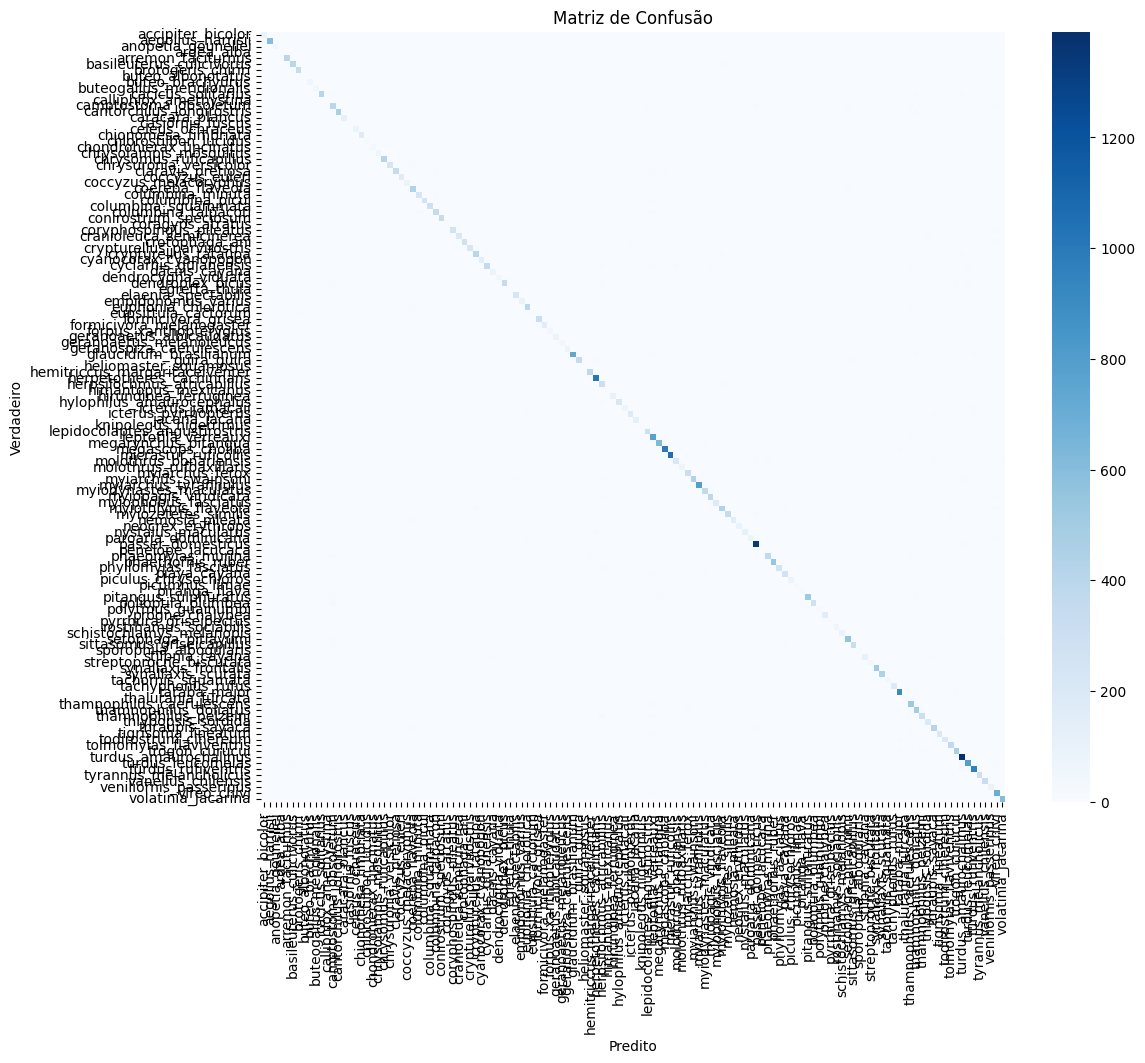

In [10]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X, y in val_loader:
        X = X.to(device)
        preds = model(X)
        preds = preds.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ============================================
# Accuracy global
# ============================================

accuracy = (all_preds == all_labels).mean()
print(f"\nAccuracy final: {accuracy:.4f}")

# ============================================
# Classification Report
# ============================================

labels_full = list(range(len(classes)))

print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_preds,
    labels=labels_full,
    target_names=classes,
    zero_division=0
))

# ============================================
# Matriz de Confusão
# ============================================

cm = confusion_matrix(all_labels, all_preds, labels=labels_full)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Matriz de Confusão")
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()

**TESTE (CNN + LSTM)**

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load("model_for_birds_new.pth", map_location=device)
model = CNN_LSTM(num_classes=len(checkpoint["classes"])).to(device)
model.load_state_dict(checkpoint["model_state_dict"])
classes = checkpoint["classes"]

In [ ]:
# from prediction import predict_species
# result = predict_species(model, "bem-te-vi.mp3", classes, device=device)

# print("Top-1:", result["top1"])
# print("Top-5:")
# for sp, p in result["top5"]:
#     print(f" - {sp}: {p:.3f}")

Top-1: ('myiodynastes_maculatus', 0.24553075432777405)
Top-5:
 - myiodynastes_maculatus: 0.246
 - megarynchus_pitangua: 0.180
 - pitangus_sulphuratus: 0.076
 - turdus_leucomelas: 0.056
 - jacana_jacana: 0.045


In [ ]:
# result = predict_species(model, "bem-te-vi2.mp3", classes, device=device)

# print("Top-1:", result["top1"])
# print("Top-5:")
# for sp, p in result["top5"]:
#     print(f" - {sp}: {p:.3f}")

Top-1: ('pitangus_sulphuratus', 0.9648763537406921)
Top-5:
 - pitangus_sulphuratus: 0.965
 - herpetotheres_cachinnans: 0.025
 - myiarchus_tyrannulus: 0.004
 - guira_guira: 0.003
 - vanellus_chilensis: 0.001


In [ ]:
# result = predict_species(model, "bem-te-vi3.mp3", classes, device=device)

# print("Top-1:", result["top1"])
# print("Top-5:")
# for sp, p in result["top5"]:
#     print(f" - {sp}: {p:.3f}")

Top-1: ('pitangus_sulphuratus', 0.7684172987937927)
Top-5:
 - pitangus_sulphuratus: 0.768
 - herpetotheres_cachinnans: 0.048
 - megascops_choliba: 0.030
 - buteogallus_meridionalis: 0.023
 - glaucidium_brasilianum: 0.017
